[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GabbyTab/boofun/blob/main/notebooks/lecture11_invariance_principle.ipynb)

# Lecture 11: Invariance Principle & Gaussian Analysis

**Topics**: Invariance Principle, Gaussian space, Majority is Stablest

**O'Donnell Chapters**: 10-11  
**Notebook by**: Gabriel Taboada

---

## Key Concepts

| Concept | Description |
|---------|-------------|
| **Invariance Principle** | Boolean functions with low influences behave like Gaussian functions |
| **Noise Stability** | $\text{Stab}_\rho[f] = \mathbb{E}[f(x) f(y)]$ where $y$ is $\rho$-correlated with $x$ |
| **Majority is Stablest** | Among balanced functions with vanishing influences, Majority maximizes stability |

In [1]:
# Install/upgrade boofun (required for Colab)
# This ensures you have the latest version with all features
!pip install --upgrade boofun -q

import boofun as bf
print(f"BooFun version: {bf.__version__}")


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/core/errormodels.py:21: UserWarning: uncertainties library not available - some error models disabled
  warnings.warn("uncertainties library not available - some error models disabled")


/Users/gabrieltaboada/dev/Boofun/boofun/src/boofun/quantum/__init__.py:22: UserWarning: Qiskit not available - quantum features limited
  warnings.warn("Qiskit not available - quantum features limited")


BooFun version: 1.1.1


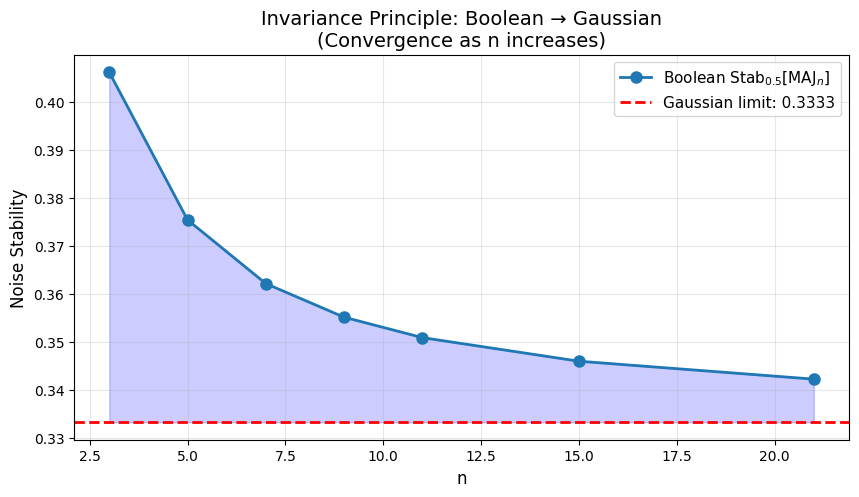

As n → ∞, Boolean functions behave like Gaussian functions!
  Gaussian limit (Sheppard): (2/π)·arcsin(ρ) = 0.3333


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import boofun as bf
from boofun.analysis import SpectralAnalyzer
from boofun.analysis.gaussian import GaussianAnalyzer
from boofun.analysis.invariance import InvarianceAnalyzer
from boofun.visualization import GrowthVisualizer

# The invariance principle: As n → ∞, Majority's noise stability converges to Gaussian
ns = [3, 5, 7, 9, 11, 15, 21]
rho = 0.5

boolean_stab = []
for n in ns:
    maj = bf.majority(n)
    # Use direct API where possible
    analyzer = SpectralAnalyzer(maj)
    boolean_stab.append(analyzer.noise_stability(rho))

# Gaussian limit (Sheppard's formula)
gaussian_limit = (2/np.pi) * np.arcsin(rho)

plt.figure(figsize=(10, 5))
plt.plot(ns, boolean_stab, 'o-', label=r'Boolean $\text{Stab}_{0.5}[\text{MAJ}_n]$', linewidth=2, markersize=8)
plt.axhline(y=gaussian_limit, color='r', linestyle='--', label=f'Gaussian limit: {gaussian_limit:.4f}', linewidth=2)
plt.fill_between(ns, boolean_stab, gaussian_limit, alpha=0.2, color='blue')
plt.xlabel('n', fontsize=12)
plt.ylabel('Noise Stability', fontsize=12)
plt.title('Invariance Principle: Boolean → Gaussian\n(Convergence as n increases)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print("As n → ∞, Boolean functions behave like Gaussian functions!")
print(f"  Gaussian limit (Sheppard): (2/π)·arcsin(ρ) = {gaussian_limit:.4f}")

In [3]:
# "Majority is Stablest": Among BALANCED, low-influence functions, 
# Majority maximizes noise stability

rho = 0.5
n = 9
gaussian_limit = (2/np.pi) * np.arcsin(rho)

print("MAJORITY IS STABLEST THEOREM")
print("="*55)
print(f"ρ = {rho}, n = {n}")
print(f"Gaussian limit for balanced functions: {gaussian_limit:.4f}")
print()

# Compare functions: stability vs max influence
functions = [
    ("Majority-9", bf.majority(9)),
    ("Parity-9", bf.parity(9)),      # Balanced, but maximally noise-sensitive
    ("Dictator-9", bf.dictator(9, 0)),  # Balanced, but high influence
]

print(f"{'Function':<15} {'Max Inf':>10} {'Stab_ρ[f]':>10} {'Balanced?':>10}")
print("-"*50)

for name, f in functions:
    analyzer = SpectralAnalyzer(f)
    stab = analyzer.noise_stability(rho)
    max_inf = max(f.influences())
    # Balanced = symmetric under negation = E[f]=0
    is_balanced = "Yes" if abs(analyzer.get_fourier_coefficient(0)) < 0.01 else "No"
    print(f"{name:<15} {max_inf:>10.4f} {stab:>10.4f} {is_balanced:>10}")

print()
print("Key insight:")
print(f"  • Majority: balanced + low influence → highest stability!")
print(f"  • Parity: balanced, but Stab_ρ = ρ^n → 0 (noise kills it)")
print(f"  • Dictator: balanced, but max influence = 1 (not 'low influence')")
print()
print("→ 'Majority is Stablest' (Mossel-O'Donnell-Oleszkiewicz, 2010)")

MAJORITY IS STABLEST THEOREM
ρ = 0.5, n = 9
Gaussian limit for balanced functions: 0.3333

Function           Max Inf  Stab_ρ[f]  Balanced?
--------------------------------------------------
Majority-9          0.2734     0.3552        Yes
Parity-9            1.0000     0.0020        Yes
Dictator-9          1.0000     0.5000        Yes

Key insight:
  • Majority: balanced + low influence → highest stability!
  • Parity: balanced, but Stab_ρ = ρ^n → 0 (noise kills it)
  • Dictator: balanced, but max influence = 1 (not 'low influence')

→ 'Majority is Stablest' (Mossel-O'Donnell-Oleszkiewicz, 2010)


## Summary

| Concept | Statement |
|---------|-----------|
| **Invariance Principle** | Low-influence Boolean functions behave like Gaussian functions |
| **Sheppard's Formula** | $\text{Stab}_\rho[\text{sgn}] = \frac{2}{\pi} \arcsin(\rho)$ |
| **Majority is Stablest** | Among balanced, low-influence functions, Majority maximizes $\text{Stab}_\rho[f]$ |
| **Implication** | Hardness of MAX-CUT (assuming Unique Games Conjecture) |

### boofun API

```python
from boofun.analysis import SpectralAnalyzer
analyzer = SpectralAnalyzer(f)
analyzer.noise_stability(rho)  # Compute Stab_ρ[f]
```